In [1]:
#
import os
import time
import io
from datetime import datetime, timedelta

#
import selenium.webdriver as webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

#
import cv2
from PIL import Image

#
import math
import random
import numpy as np
import pandas as pd

#
from matplotlib import pyplot as plt
from IPython.display import clear_output

#
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

#
from albumentations.pytorch.functional import img_to_tensor

#
from collections import deque

In [2]:
#
DATA_DIR = 'data/games'

#
IMAGE_SIZE = (128, 128)

# rewards
POS_REWARD = 1
NEG_REWARD = -1

In [3]:
class Game():
    
    def __init__(self, options, fps=10, save=False):
        
        # open browser
        self.driver = webdriver.Chrome(options=options)
        self.driver.get('https://flappybird.online/')
        
        #
        self.board = WebDriverWait(self.driver, 10).until(
            EC.presence_of_element_located((By.ID, "flyarea"))
        )
        
        self.score_elem = self.board.find_element_by_xpath('//div[@id="bigscore"]')
        self.player_elem = self.board.find_element_by_xpath('//div[@id="player"]')
        self.scoreboard_elem = self.board.find_element_by_xpath('//div[@id="scoreboard"]')

        #
        self.id = hex(int(time.time()))
        self.last_frame_captured = datetime.utcnow()
        self.fps = fps
        self.spf = 1. / fps
        
        #
        self.frames = []
        self.score = None
        self.previous_score = None
        
        self.save = save
                
        # create game directory
        if self.save:
            os.mkdir(os.path.join(DATA_DIR, self.id))
        
    def init_game(self):
        while True:        
            # break on init image
            if self.is_lobby():
                break
                
            # break on init image
            if self.is_game_over():
                time.sleep(0.1)
                self.press_space()
                
    def reset(self):
        
        #
        self.id = hex(int(time.time()))
        self.last_frame_captured = datetime.utcnow()
        
        #
        self.frames = []
        self.score = None
        self.previous_score = None
        
        #
        self.init_game()
                
    def start_game(self):
        while self.is_game_over():
            self.init_game()
            
        while self.is_lobby():
            self.press_space()
            frame = self.grab_frame()
        
        self.frames.append(frame)
        return frame
          
    def is_game_over(self):
        return self.player_state() == 'paused'
        
    def is_lobby(self):
        return self.current_score() == None and self.player_state() == 'running'
    
    def is_started(self):
        return self.current_score() != None and self.player_state() == 'running'
    
    def parse_style(self, style):
        def split(x):
            return x.split(':')
        
        def filter_empty(x):
            return x[0] != ''
        
        def strip(x):
            if len(x) > 1:
                return (x[0].strip(), x[1].strip())
            return x
        
        styles = style.split(';')
        key_values = list(map(strip, filter(filter_empty, map(split, styles))))
        return dict(key_values)
    
    def player_state(self):
        player_dict = self.parse_style(self.player_elem.get_attribute('style'))
        return player_dict['animation-play-state']
    
    def wait_next_frame(self):
        next_frame_time = self.last_frame_captured + timedelta(seconds=self.spf)
        diff = next_frame_time - datetime.utcnow()
        if diff.total_seconds() > 0:
            time.sleep(diff.total_seconds())
    
    def grab_frame(self):
        
        # wait for next frame to grab
        self.wait_next_frame()

        # grab frame as bytes and convert them to image
        frame = Image.open(io.BytesIO(self.board.screenshot_as_png))
        frame = frame.resize(IMAGE_SIZE)
        frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
        
        self.last_frame_captured = datetime.utcnow()
        
        if self.save:
            cv2.imwrite(os.path.join(
                DATA_DIR, 
                str(self.id), 
                '{}.png'.format(str(len(self.frames)))
            ), frame)
            
        self.frames.append(frame)
        return frame
    
    def press_space(self):
        action_chains = ActionChains(self.driver)
        action_chains.send_keys(Keys.SPACE)
        action_chains.perform()
        
    def move(self, move):
        if move == 1:
            # press button
            self.press_space()
        elif move == 0:
            # do nothing
            pass
        
        next_state = self.grab_frame()
        reward = self.reward()
        done = self.is_game_over()
        return next_state, reward, done
        
    def reward(self):
        if self.is_game_over():
            return NEG_REWARD
        
        score = self.current_score()
        self.previous_score = self.score
        self.score = score

        if self.previous_score != None and score != None and self.previous_score < score:
            # return POS_REWARD
            pass
        
        return len(self.frames) / 100.
    
    def current_score(self):
        try:
            return int(self.score_elem.find_element_by_xpath('./img').get_attribute('alt'))
        except Exception as e:
            return None
    

In [4]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)
    

def compute_td_loss(batch_size):
    if batch_size > len(replay_buffer):
        return None
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = Variable(torch.FloatTensor(state))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(next_state))
    
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    q_values = model(state)        
    next_q_values = model(next_state)

    q_value  = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss


def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state_ = Variable(img_to_tensor(state).unsqueeze(0))
            q_value = self.forward(state_)
            action = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(self.num_actions)
        return action

In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

input_shape = (3, *IMAGE_SIZE)
action_space = 2
USE_CUDA = False
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

model = CnnDQN(input_shape, action_space)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [6]:
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('--mute-audio')
options.add_argument('window-size=400x600')

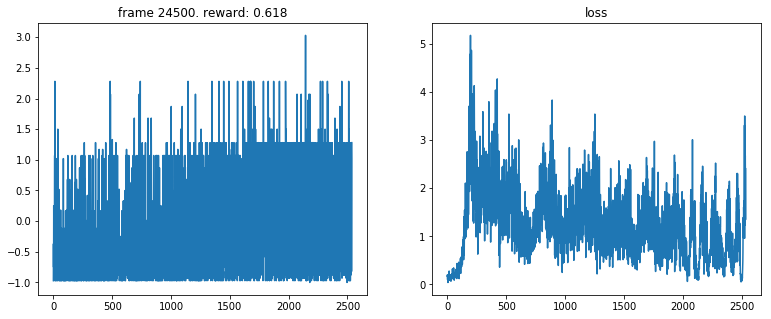

In [ ]:
num_frames = 1400000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

# set up game
fps = 10
game = Game(options, fps=fps, save=False)
# rewards = pd.DataFrame(columns=['Frame', 'Reward'])
game.init_game()
state = game.start_game()
    
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done = game.move(action)
    replay_buffer.push(
        img_to_tensor(state), 
        action, 
        reward, 
        img_to_tensor(next_state), 
        done
    )
    
    state = next_state
    episode_reward += reward
    
    if done:
        loss = compute_td_loss(batch_size)
        if loss:
            losses.append(loss.data)
            
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        # reset
        game.reset()
        state = game.start_game()
        
    """if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])"""
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)